2025-11-07 19:59:00.897 python[61961:21889449] +[IMKClient subclass]: chose IMKClient_Modern
2025-11-07 19:59:01.979 python[61961:21889449] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'
2025-11-07 19:59:10.243 python[61961:21889449] +[IMKInputSession subclass]: chose IMKInputSession_Modern



Global calibration (controls): a=1.78476e-05, b=0.331429, R²=0.894, R=0.946, p=2.64e-53

Predicted concentrations (g/dL) — using GLOBAL model
Lane  Band     IOD  Conc (g/dL)
-------------------------------
230   Albumin  203180        3.958
230   Alpha1   25011        0.778
230   Alpha2   14798        0.596
230   Beta     43786        1.113
230   Gamma    1912        0.366
231   Albumin  186778        3.665
231   Alpha1   13914        0.580
231   Alpha2   13184        0.567
231   Beta     84073        1.832
231   Gamma    1810        0.364
232   Albumin  150144        3.011
232   Alpha1   18982        0.670
232   Alpha2   12540        0.555
232   Beta     17581        0.645
232   Gamma    348        0.338



Save predicted concentrations to CSV? [y/N]:  y
Filename (without extension) [default: sample_concentrations_global]:  Sample1_Pilot_SPEPv8


Saved: Sample1_Pilot_SPEPv8.csv



PNG filename for pooled calibration (without extension) [default: QC_global]:  Pilot_SPEPv8


Saved pooled QC: Pilot_SPEPv8.png


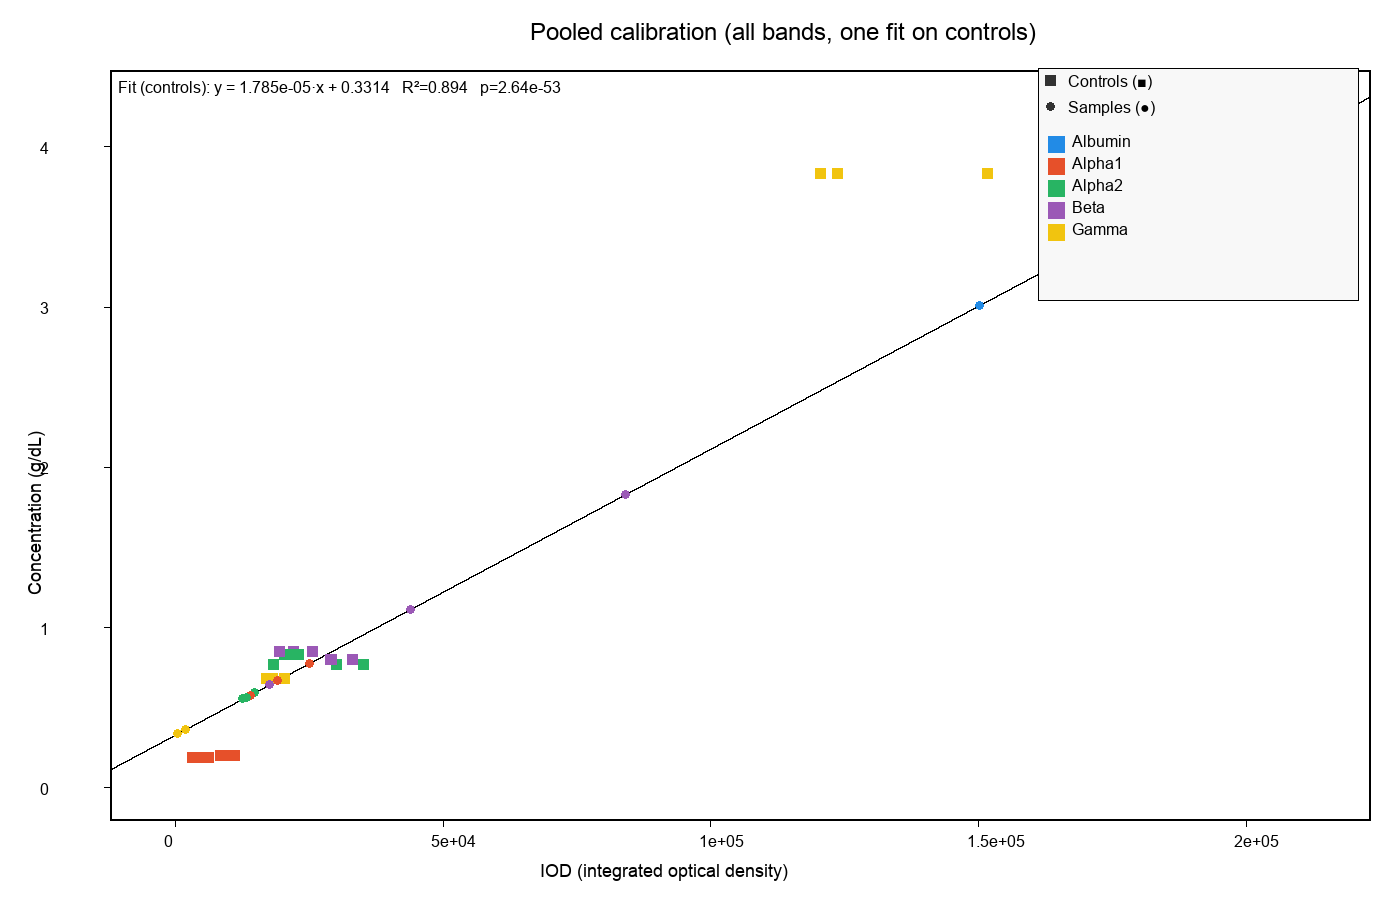


Done.


In [1]:
# ===============================================
# Vk*MYC SPEP Analyzer — Global Calibration (Pure-Python)
# - Named lanes & bands; grouped control entry by lane name
# - Dual-view pickers (full gel + zoomed lane)
# - ONE pooled linear calibration from ALL control bands
# - Prediction uses the single global model (a_global, b_global)
# - Prints R², R, and an approximate two-sided p-value (no SciPy)
# - Notebook table output + "Save-as-CSV" prompt
# - Pooled QC plot (PIL only), asks for PNG filename
# - Rotated y-axis label + roomy margins; copy-friendly PNG
# ===============================================

import os, math, statistics, contextlib, io
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

from PIL import Image, ImageTk, ImageDraw, ImageFont
import tkinter as tk
from tkinter import filedialog, simpledialog, messagebox

# Inline display in Jupyter
try:
    from IPython.display import display
except Exception:
    display = None

# ---------------- CONFIG ----------------
IMAGE_PATH = ""         # leave empty to pick interactively
DEFAULT_BANDS = ["Albumin", "Alpha1", "Alpha2", "Beta", "Gamma"]

FIT_THRU_ORIGIN = False   # global fit through origin?
CLAMP_NONNEG    = True    # clamp predicted g/dL to >= 0

GROUP_CONTROLS_BY_LANE_NAME = True  # same-name controls prompted once
CONTROL_NAME_NORMALIZE      = True  # collapse whitespace for grouping

SHOW_QC_INLINE  = True     # show pooled QC plot inline
# ----------------------------------------

# --------- Force pure-Python (avoid NumPy/SciPy entirely) ----------
def lazy_np():  # keeps older envs happy
    return None

# ---------- Data classes ----------
@dataclass
class Rect:
    x: float; y: float; w: float; h: float

@dataclass
class Lane:
    lane_id: str
    lane_type: str  # "NEG","POS","SAMPLE"
    name: str
    rect: Rect

@dataclass
class Band:
    lane_id: str
    band_name: str
    rect: Rect

# ---------- Image helpers ----------
def load_image_gray(path: str) -> Image.Image:
    img = Image.open(path)
    if img.mode != "L":
        img = img.convert("L")
    return img

def crop(img: Image.Image, r: Rect) -> Image.Image:
    x0 = max(0, int(round(r.x))); y0 = max(0, int(round(r.y)))
    x1 = min(img.width, int(round(r.x+r.w))); y1 = min(img.height, int(round(r.y+r.h)))
    return img.crop((x0, y0, x1, y1))

def iod_intensity(roi: Image.Image) -> float:
    # invert (dark bands -> high signal), background = median of 10% border, sum positive
    inv = Image.eval(roi, lambda p: 255 - p)
    w, h = inv.size
    px = list(inv.getdata())
    b = max(1, int(0.1 * min(w, h)))
    top = px[:w*b]; bot = px[-w*b:] if h>b else []
    left = []; right = []
    for yy in range(h):
        row = yy*w
        left.extend(px[row:row+b]); right.extend(px[row+(w-b):row+w])
    border = top + bot + left + right
    bg = statistics.median(border) if border else 0
    return float(sum(max(v-bg, 0) for v in px))

# ---------- Tk utilities ----------
def _fit_scale(img: Image.Image, max_w: int, max_h: int):
    scale = min(max_w/img.width, max_h/img.height, 1.0)
    return (img.resize((int(img.width*scale), int(img.height*scale)), Image.BILINEAR), scale)

class LaneSelector:
    def __init__(self, img: Image.Image, label="LANES"):
        self.img = img
        self.root = tk.Tk()
        self.root.title(f"Select {label} — Enter/Esc=Done, u=Undo")
        scr_w = self.root.winfo_screenwidth(); scr_h = self.root.winfo_screenheight()
        disp, self.scale = _fit_scale(img, int(scr_w*0.9), int(scr_h*0.85))
        self.tk_img = ImageTk.PhotoImage(disp)
        self.canvas = tk.Canvas(self.root, width=disp.width, height=disp.height, cursor="cross")
        self.canvas.grid(row=0, column=0, sticky="nsew")
        self.root.grid_rowconfigure(0, weight=1); self.root.grid_columnconfigure(0, weight=1)
        self.canvas.create_image(0,0,image=self.tk_img,anchor="nw")
        self.canvas.create_text(10,10,anchor="nw",
            text="Drag to add lane rectangles. You'll be asked to name each.",
            fill="lime", font=("Helvetica",12,"bold"))
        btn = tk.Frame(self.root); btn.grid(row=1,column=0,sticky="ew")
        tk.Button(btn,text="Undo",command=self.undo).pack(side=tk.LEFT,padx=6,pady=6)
        tk.Button(btn,text="Done",command=self.finish).pack(side=tk.RIGHT,padx=6,pady=6)
        self.root.bind("<Return>",lambda e:self.finish())
        self.root.bind("<Escape>",lambda e:self.finish())
        self.root.bind("u",lambda e:self.undo())
        self.root.bind("<BackSpace>",lambda e:self.undo())
        self.start=None; self._curr=None
        self.can_ids=[]; self.rects=[]; self.names=[]
        self.canvas.bind("<ButtonPress-1>",self.on_press)
        self.canvas.bind("<B1-Motion>",self.on_drag)
        self.canvas.bind("<ButtonRelease-1>",self.on_release)
    def on_press(self,e):
        self.start=(e.x,e.y)
        self._curr=self.canvas.create_rectangle(e.x,e.y,e.x,e.y,outline="lime",width=2)
    def on_drag(self,e):
        if self._curr and self.start:
            x0,y0=self.start; self.canvas.coords(self._curr,x0,y0,e.x,e.y)
    def on_release(self,e):
        if not self._curr or not self.start: return
        x0,y0=self.start; x1,y1=e.x,e.y
        x,y=min(x0,x1),min(y0,y1); w,h=abs(x1-x0),abs(y1-y0)
        if w>=2 and h>=2:
            self.can_ids.append(self._curr)
            rx,ry=x/self.scale,y/self.scale; rw,rh=w/self.scale,h/self.scale
            self.rects.append(Rect(rx,ry,rw,rh))
            nm=simpledialog.askstring("Lane name","Name for this lane:",parent=self.root)
            if not nm: nm=f"Lane-{len(self.rects)}"
            self.names.append(nm)
            self.canvas.create_text(x+4,y+14,anchor="nw",text=nm,fill="yellow",font=("Helvetica",11,"bold"))
        else:
            self.canvas.delete(self._curr)
        self._curr=None; self.start=None
    def undo(self):
        if self.can_ids:
            self.canvas.delete(self.can_ids.pop()); self.rects.pop(); self.names.pop()
    def finish(self):
        try:self.root.destroy()
        except:pass
    def select(self):
        self.root.mainloop()
        return list(zip(self.rects,self.names))

class BandSelectorDual:
    def __init__(self, full_img: Image.Image, lane_rect: Rect, title="Select bands"):
        self.full=full_img; self.lane_rect=lane_rect
        self.root=tk.Tk(); self.root.title(title)
        scr_w=self.root.winfo_screenwidth(); scr_h=self.root.winfo_screenheight()
        left_w=int(scr_w*0.45); right_w=int(scr_w*0.45); max_h=int(scr_h*0.9)
        dispL,self.scaleL=_fit_scale(self.full,left_w,max_h)
        self.tkL=ImageTk.PhotoImage(dispL)
        self.canvasL=tk.Canvas(self.root,width=dispL.width,height=dispL.height)
        self.canvasL.grid(row=0,column=0,sticky="nsew",padx=(8,4),pady=8)
        self.canvasL.create_image(0,0,image=self.tkL,anchor="nw")
        x,y,w,h=lane_rect.x*self.scaleL,lane_rect.y*self.scaleL,lane_rect.w*self.scaleL,lane_rect.h*self.scaleL
        self.canvasL.create_rectangle(x,y,x+w,y+h,outline="deepskyblue",width=3)
        lane_img=crop(self.full,lane_rect)
        dispR,self.scaleR=_fit_scale(lane_img,right_w,max_h)
        self.tkR=ImageTk.PhotoImage(dispR)
        self.canvasR=tk.Canvas(self.root,width=dispR.width,height=dispR.height,cursor="cross")
        self.canvasR.grid(row=0,column=1,sticky="nsew",padx=(4,8),pady=8)
        self.canvasR.create_image(0,0,image=self.tkR,anchor="nw")
        self.canvasR.create_text(8,10,anchor="nw",
            text="Draw band rectangles (top→bottom). Enter/Esc=Done, u=Undo",
            fill="lime",font=("Helvetica",12,"bold"))
        self.root.grid_columnconfigure(0,weight=1);self.root.grid_columnconfigure(1,weight=1)
        self.root.grid_rowconfigure(0,weight=1)
        btn=tk.Frame(self.root);btn.grid(row=1,column=0,columnspan=2,sticky="ew")
        tk.Button(btn,text="Undo",command=self.undo).pack(side=tk.LEFT,padx=6,pady=6)
        tk.Button(btn,text="Done",command=self.finish).pack(side=tk.RIGHT,padx=6,pady=6)
        self.root.bind("<Return>",lambda e:self.finish())
        self.root.bind("<Escape>",lambda e:self.finish())
        self.root.bind("u",lambda e:self.undo())
        self.root.bind("<BackSpace>",lambda e:self.undo())
        self.start=None;self._curr=None;self.can_ids=[];self.rects_local=[]
        self.canvasR.bind("<ButtonPress-1>",self.on_press)
        self.canvasR.bind("<B1-Motion>",self.on_drag)
        self.canvasR.bind("<ButtonRelease-1>",self.on_release)
    def on_press(self,e):
        self.start=(e.x,e.y)
        self._curr=self.canvasR.create_rectangle(e.x,e.y,e.x,e.y,outline="lime",width=2)
    def on_drag(self,e):
        if self._curr and self.start:
            x0,y0=self.start;self.canvasR.coords(self._curr,x0,y0,e.x,e.y)
    def on_release(self,e):
        if not self._curr or not self.start:return
        x0,y0=self.start;x1,y1=e.x,e.y
        x,y=min(x0,x1),min(y0,y1);w,h=abs(x1-x0),abs(y1-y0)
        if w>=2 and h>=2:
            self.can_ids.append(self._curr)
            rx,ry=x/self.scaleR,y/self.scaleR;rw,rh=w/self.scaleR,h/self.scaleR
            self.rects_local.append(Rect(rx,ry,rw,rh))
        else:self.canvasR.delete(self._curr)
        self._curr=None;self.start=None
    def undo(self):
        if self.can_ids:
            self.canvasR.delete(self.can_ids.pop());self.rects_local.pop()
    def finish(self):
        try:self.root.destroy()
        except:pass
    def select(self):
        self.root.mainloop();return self.rects_local

# ---------- Selection helpers ----------
def select_lanes(img: Image.Image, label: str) -> List[Lane]:
    ls=LaneSelector(img,label=f"{label} LANES")
    rects_and_names=ls.select()
    return [Lane(lane_id=f"{label}-{i+1}", lane_type=label, name=n, rect=r)
            for i,(r,n) in enumerate(rects_and_names)]

def select_bands(img: Image.Image, lane: Lane) -> List[Rect]:
    bs=BandSelectorDual(img,lane.rect,title=f"{lane.lane_type} / {lane.name}")
    return bs.select()

def name_control_bands(n:int,preset:Optional[List[str]]=None)->List[str]:
    names=preset[:] if preset else (DEFAULT_BANDS[:n] if n==5 else [f"Band{i+1}" for i in range(n)])
    out=[]
    for i in range(n):
        nm=simpledialog.askstring("Band name",f"Name for control band #{i+1}:",initialvalue=names[i])
        out.append(nm if nm else names[i])
    return out

def prompt_control_concs(lane_name:str, band_names:List[str])->Dict[str,float]:
    concs={}
    for bn in band_names:
        while True:
            val=simpledialog.askstring("Control concentration",f"{lane_name} — {bn} (g/dL):")
            if val is None or val.strip()=="":
                if messagebox.askyesno("Skip?","Blank input. Skip this band?"): break
                else: continue
            try: concs[bn]=float(val);break
            except: messagebox.showerror("Invalid","Please enter a number.")
    return concs

def normalize_name(s: str) -> str:
    if s is None: return ""
    t = s.strip()
    if CONTROL_NAME_NORMALIZE:
        t = " ".join(t.split())
    return t

# ---------- Regression / Stats (pure-Python) ----------
def linear_fit(x_list, y_list, through_origin=False):
    if through_origin:
        sxx = sum(v*v for v in x_list)
        sxy = sum(x*y for x,y in zip(x_list,y_list))
        a = sxy / (sxx + 1e-12); b = 0.0
        return a, b
    n=len(x_list); sx=sum(x_list); sy=sum(y_list)
    sxx=sum(v*v for v in x_list)
    sxy=sum(x*y for x,y in zip(x_list,y_list))
    denom = n*sxx - sx*sx
    if abs(denom) < 1e-12:
        a = sxy/(sxx+1e-12); b = 0.0
    else:
        a = (n*sxy - sx*sy)/denom; b = (sy - a*sx)/n
    return a, b

def r_squared(x_list, y_list, a, b) -> float:
    yhat = [a*x + b for x in x_list]
    ybar = sum(y_list)/len(y_list)
    ss_res = sum((y - yh)**2 for y, yh in zip(y_list, yhat))
    ss_tot = sum((y - ybar)**2 for y in y_list)
    return 1.0 - (ss_res / ss_tot if ss_tot > 0 else 0.0)

# Approximate two-sided p-value for slope (no SciPy), good when df ≳ 8–10
def slope_pvalue(x_list, y_list, a, b, through_origin=False) -> Optional[float]:
    n = len(x_list)
    if n < (2 if through_origin else 3):
        return None
    rss = sum((y - (a*x + b))**2 for x, y in zip(x_list, y_list))
    if through_origin:
        sxx = sum(x*x for x in x_list)
        df = n - 1
        sigma2 = rss / max(df, 1)
        var_a = sigma2 / max(sxx, 1e-12)
    else:
        xbar = sum(x_list)/n
        sxx = sum((x - xbar)**2 for x in x_list)
        df = n - 2
        sigma2 = rss / max(df, 1)
        var_a = sigma2 / max(sxx, 1e-12)
    se_a = math.sqrt(max(var_a, 0.0))
    if se_a == 0: return None
    z = abs(a) / se_a  # use normal approx to t
    # Normal tail approx (Abramowitz–Stegun)
    t1 = 1.0 / (1.0 + 0.2316419*z)
    poly = (0.319381530*t1
            - 0.356563782*t1**2
            + 1.781477937*t1**3
            - 1.821255978*t1**4
            + 1.330274429*t1**5)
    phi = math.exp(-0.5*z*z) / (2.5066282746310002)  # 1/sqrt(2π)
    p = 2 * (phi * poly)
    return float(min(max(p, 0.0), 1.0))

# ---------- Global calibration (pooled) ----------
def global_calibration_from_controls(measured: List[Dict], controls: List[Dict]) -> Tuple[float,float,Dict]:
    meas = {(r["lane_id"], r["band_name"]): r["iod_intensity"] for r in measured}
    xs, ys = [], []
    for c in controls:
        key = (c["lane_id"], c["band_name"])
        if key in meas and c.get("conc_g_dl") is not None:
            xs.append(float(meas[key])); ys.append(float(c["conc_g_dl"]))
    if not xs:
        raise RuntimeError("No valid control points for global calibration.")
    a, b = linear_fit(xs, ys, through_origin=FIT_THRU_ORIGIN)
    R2 = r_squared(xs, ys, a, b)
    p  = slope_pvalue(xs, ys, a, b, through_origin=FIT_THRU_ORIGIN)
    return a, b, dict(R2=R2, p=p, n=len(xs))

# ---------- Prediction using GLOBAL model ----------
def predict_with_global(measured: List[Dict], a: float, b: float, sample_ids: List[str], lane_name_map: Dict[str,str]) -> List[Dict]:
    out=[]
    for r in measured:
        if r["lane_id"] in sample_ids:
            pred = a*r["iod_intensity"] + b
            if CLAMP_NONNEG:
                pred = max(0.0, pred)
            out.append(dict(
                lane_id=r["lane_id"],
                lane_name=lane_name_map.get(r["lane_id"], r["lane_id"]),
                band_name=r["band_name"],
                iod_intensity=r["iod_intensity"],
                conc_g_dl_est=pred
            ))
    return out

# ---------- CSV + pretty print ----------
def write_csv(path:str, rows:List[Dict], header:Optional[List[str]]=None):
    import csv
    if not rows and not header: return
    if header is None: header = list(rows[0].keys())
    with open(path,"w",newline="") as f:
        w = csv.DictWriter(f, fieldnames=header); w.writeheader()
        for r in rows: w.writerow(r)

def print_table(rows: List[Dict]):
    if not rows:
        print("(no rows)"); return
    cols = ["Lane", "Band", "IOD", "Conc (g/dL)"]
    w_lane = max(len(cols[0]), max(len(r["lane_name"]) for r in rows))
    w_band = max(len(cols[1]), max(len(r["band_name"]) for r in rows))
    w_iod  = len(cols[2]); w_pred = len(cols[3])
    print(f"{cols[0]:<{w_lane}}  {cols[1]:<{w_band}}  {cols[2]:>{w_iod}}  {cols[3]:>{w_pred}}")
    print("-"*(w_lane+w_band+w_iod+w_pred+6))
    for r in rows:
        iod = f"{r['iod_intensity']:.0f}"
        pred = "NA" if r["conc_g_dl_est"] is None or math.isnan(r["conc_g_dl_est"]) else f"{r['conc_g_dl_est']:.3f}"
        print(f"{r['lane_name']:<{w_lane}}  {r['band_name']:<{w_band}}  {iod:>{w_iod}}  {pred:>{w_pred}}")

# ---------- Pooled QC plot (PIL) ----------
def plot_pooled_correlation_pil(measured, controls, pred, a, b, R2, pval,
                                show_inline=True,
                                save_path="QC_global.png",
                                width=1400, height=900):
    meas = {(r["lane_id"], r["band_name"]): r["iod_intensity"] for r in measured}
    pred_map = {(r["lane_id"], r["band_name"]): r["conc_g_dl_est"] for r in pred}

    # collect points
    ctrl_xy, samp_xyb = [], []
    bands_seen = []
    for c in controls:
        key = (c["lane_id"], c["band_name"])
        if key in meas and c.get("conc_g_dl") is not None:
            x = float(meas[key]); y = float(c["conc_g_dl"])
            ctrl_xy.append((x, y, c["band_name"]))
            if c["band_name"] not in bands_seen:
                bands_seen.append(c["band_name"])
    sample_ids = set(r["lane_id"] for r in pred)
    for (lid, band), x in meas.items():
        if lid in sample_ids:
            y = pred_map.get((lid, band))
            if y is not None and not math.isnan(y):
                samp_xyb.append((float(x), float(y), band))
                if band not in bands_seen:
                    bands_seen.append(band)

    # axis limits
    xs_all = [x for x,_,_ in ctrl_xy] + [x for x,_,_ in samp_xyb]
    ys_all = [y for _,y,_ in ctrl_xy] + [y for _,y,_ in samp_xyb] + [a*min([x for x,_,_ in ctrl_xy])+b, a*max([x for x,_,_ in ctrl_xy])+b]
    xmin, xmax = min(xs_all), max(xs_all)
    if xmin == xmax: xmin -= 1.0; xmax += 1.0
    ymin, ymax = min(ys_all), max(ys_all)
    if ymin == ymax: ymin -= 1.0; ymax += 1.0
    xpad = 0.06*(xmax-xmin); ypad = 0.10*(ymax-ymin)
    xmin -= xpad; xmax += xpad; ymin -= ypad; ymax += ypad

    def to_px(x, vmin, vmax, p0, p1):
        if vmax <= vmin: return (p0+p1)/2
        t = (x-vmin)/(vmax-vmin); return p0 + t*(p1-p0)
    def nice_ticks(vmin, vmax, nticks=7):
        if vmin == vmax: return [vmin]*nticks
        span = vmax-vmin
        step = 10 ** math.floor(math.log10(span/nticks))
        for m in [1,2,5,10]:
            if span/(step*m) <= nticks: step*=m; break
        start = math.floor(vmin/step)*step
        vals=[]; v=start
        for _ in range(120):
            if v>vmax+1e-9 and len(vals)>=nticks: break
            vals.append(v); v+=step
        return vals

    palette = [
        (34,139,230), (230,80,42), (40,180,99), (155,89,182), (241,196,15),
        (231,76,60), (52,152,219), (46,204,113), (241,148,138), (26,188,156)
    ]
    color_map = {bn: palette[i % len(palette)] for i, bn in enumerate(bands_seen)}

    L,R,T,B = 110, 30, 70, 80
    plot_w, plot_h = width - L - R, height - T - B
    img = Image.new("RGB", (width, height), "white")
    drw = ImageDraw.Draw(img)
    try:
        f_title = ImageFont.truetype("Arial.ttf", 24)
        f_axis  = ImageFont.truetype("Arial.ttf", 18)
        f_tick  = ImageFont.truetype("Arial.ttf", 16)
        f_leg   = ImageFont.truetype("Arial.ttf", 16)
    except Exception:
        f_title=f_axis=f_tick=f_leg=ImageFont.load_default()

    x0,y0 = L,T; x1,y1 = L+plot_w, T+plot_h
    drw.rectangle([x0,y0,x1,y1], outline="black", width=2)

    for t in nice_ticks(xmin,xmax,7):
        px = to_px(t, xmin, xmax, x0, x1); drw.line([px,y1,px,y1+6], fill="black")
        drw.text((px-12, y1+12), f"{t:.2g}", font=f_tick, fill="black")
    for t in nice_ticks(ymin,ymax,7):
        py = to_px(t, ymin, ymax, y1, y0); drw.line([x0-6,py,x0,py], fill="black")
        drw.text((x0-70, py-8), f"{t:.2g}", font=f_tick, fill="black")

    drw.text((x0 + plot_w//2 - 210, 18), "Pooled calibration (all bands, one fit on controls)", font=f_title, fill="black")
    drw.text((x0 + plot_w//2 - 200, y1 + 40), "IOD (integrated optical density)", font=f_axis, fill="black")
    ylab = Image.new("RGBA", (300, 40), (255,255,255,0))
    ImageDraw.Draw(ylab).text((0,0), "Concentration (g/dL)", font=f_axis, fill="black")
    ylab = ylab.rotate(90, expand=True); img.paste(ylab, (24, y0 + plot_h//2 - ylab.size[1]//2), ylab)

    # global fit line
    px0 = to_px(xmin, xmin, xmax, x0, x1); py0 = to_px(a*xmin+b, ymin, ymax, y1, y0)
    px1 = to_px(xmax, xmin, xmax, x0, x1); py1 = to_px(a*xmax+b, ymin, ymax, y1, y0)
    drw.line([px0,py0,px1,py1], fill="black", width=2)

    def dot(px,py,color,r=4): drw.ellipse([px-r,py-r,px+r,py+r], fill=color, outline=color)
    def square(px,py,color,r=5): drw.rectangle([px-r,py-r,px+r,py+r], fill=color, outline=color)

    for x,y,band in ctrl_xy:
        col = color_map.get(band,(50,50,50))
        square(to_px(x,xmin,xmax,x0,x1), to_px(y,ymin,ymax,y1,y0), col)
    for x,y,band in samp_xyb:
        col = color_map.get(band,(120,120,120))
        dot(to_px(x,xmin,xmax,x0,x1), to_px(y,ymin,ymax,y1,y0), col)

    leg_x, leg_y = x1 - 320, y0 + 10
    drw.rectangle([leg_x-12, leg_y-12, x1-12, leg_y+220], outline="black", fill=(248,248,248))
    square(leg_x, leg_y, (50,50,50)); drw.text((leg_x+18, leg_y-8), "Controls (■)", font=f_leg, fill="black")
    dot   (leg_x, leg_y+26, (50,50,50)); drw.text((leg_x+18, leg_y+18), "Samples (●)",  font=f_leg, fill="black")
    y_ptr = leg_y + 52
    for bn in color_map.keys():
        col = color_map[bn]
        drw.rectangle([leg_x-2, y_ptr+4, leg_x+14, y_ptr+20], fill=col, outline=col)
        drw.text((leg_x+22, y_ptr), bn, font=f_leg, fill="black")
        y_ptr += 22

    txt = f"Fit (controls): y = {a:.4g}·x {'+' if b>=0 else '-'} {abs(b):.4g}   R²={R2:.3f}   p={'N/A' if pval is None else f'{pval:.3g}'}"
    drw.text((x0+8, y0+8), txt, font=f_tick, fill="black")

    if save_path:
        img.save(save_path); print(f"Saved pooled QC: {save_path}")
    if show_inline and display is not None:
        display(img)

# ======================= MAIN =======================
# 1) pick image
if not IMAGE_PATH:
    root=tk.Tk();root.withdraw()
    IMAGE_PATH=filedialog.askopenfilename(title="Choose gel image",
                                          filetypes=[("Images","*.jpg *.jpeg *.png *.tif *.tiff")])
    root.destroy()
if not IMAGE_PATH: raise SystemExit("No image selected.")
img=load_image_gray(IMAGE_PATH)

# 2) select lanes (you name each)
neg_lanes=select_lanes(img,"NEG")
pos_lanes=select_lanes(img,"POS")
sample_lanes=select_lanes(img,"SAMPLE")
all_lanes=neg_lanes+pos_lanes+sample_lanes
if not all_lanes: raise SystemExit("No lanes selected.")

# 3) select bands – name once on first control; reuse for all others/samples
band_names_master=None
all_bands=[]

def collect_for_lane(lane: Lane, need_names: bool) -> List[Band]:
    global band_names_master
    rects = select_bands(img, lane)
    if need_names:
        band_names_master = name_control_bands(len(rects), preset=DEFAULT_BANDS if len(rects)==5 else None)
        names = band_names_master
    else:
        names = (band_names_master if (band_names_master and len(band_names_master)==len(rects))
                 else [f"Band{i+1}" for i in range(len(rects))])
    bands=[]
    for nm, r in zip(names, rects):
        bands.append(Band(lane_id=lane.lane_id,
                          band_name=nm,
                          rect=Rect(r.x + lane.rect.x, r.y + lane.rect.y, r.w, r.h)))
    return bands

first_control_done=False
for lane in (neg_lanes + pos_lanes):
    blist = collect_for_lane(lane, need_names=(not first_control_done))
    if not first_control_done: first_control_done=True
    all_bands.extend(blist)
for lane in sample_lanes:
    all_bands.extend(collect_for_lane(lane, need_names=False))

# 4) measure IOD per band
measured=[]
for b in all_bands:
    iod = iod_intensity(crop(img, b.rect))
    measured.append(dict(lane_id=b.lane_id, band_name=b.band_name, iod_intensity=iod))

# 5) enter control concentrations (group by identical lane NAME if enabled)
controls = []
control_lanes = neg_lanes + pos_lanes
if GROUP_CONTROLS_BY_LANE_NAME:
    messagebox.showinfo(
        "Control entry rule",
        "Controls with the SAME lane name will share entered concentrations.\n\n"
        "Example: lanes named 'Negative' will be prompted once and applied to all.\n"
        "Different names like 'Negative 1' vs 'Negative 2' will be prompted separately."
    )
    groups = {}
    for ln in control_lanes:
        key = (ln.lane_type, normalize_name(ln.name))
        groups.setdefault(key, []).append(ln)
    for (lane_type, _), lanes_in_group in groups.items():
        rep = lanes_in_group[0]
        band_list = band_names_master or sorted({r['band_name'] for r in measured if r['lane_id'] == rep.lane_id})
        label = f"{lane_type} / {rep.name}  (applies to {len(lanes_in_group)} lane(s))"
        concs = prompt_control_concs(label, band_list)
        for ln in lanes_in_group:
            for bn, val in concs.items():
                controls.append(dict(lane_id=ln.lane_id, band_name=bn, conc_g_dl=val))
else:
    for lane in control_lanes:
        band_list = band_names_master or sorted({r['band_name'] for r in measured if r['lane_id'] == lane.lane_id})
        concs = prompt_control_concs(f"{lane.lane_type} / {lane.name}", band_list)
        for bn, val in concs.items():
            controls.append(dict(lane_id=lane.lane_id, band_name=bn, conc_g_dl=val))

if not controls: raise SystemExit("No control concentrations provided.")

# 6) global calibration (pooled) and prediction with global model
a_glob, b_glob, diag = global_calibration_from_controls(measured, controls)
R = math.sqrt(max(diag["R2"], 0.0))
lane_name_map = {l.lane_id: l.name for l in all_lanes}
sample_ids = [l.lane_id for l in sample_lanes]
pred = predict_with_global(measured, a_glob, b_glob, sample_ids, lane_name_map)

print(f"\nGlobal calibration (controls): a={a_glob:.6g}, b={b_glob:.6g}, "
      f"R²={diag['R2']:.3f}, R={R:.3f}, p={'N/A' if diag['p'] is None else f'{diag['p']:.3g}'}")

# 7) results table + optional CSV
print("\nPredicted concentrations (g/dL) — using GLOBAL model")
print_table(pred)
resp = input("\nSave predicted concentrations to CSV? [y/N]: ").strip().lower()
if resp == "y":
    fname = input("Filename (without extension) [default: sample_concentrations_global]: ").strip()
    if not fname: fname = "sample_concentrations_global"
    write_csv(fname + ".csv", pred,
              header=["lane_id","lane_name","band_name","iod_intensity","conc_g_dl_est"])
    print(f"Saved: {fname}.csv")

# 8) pooled QC plot (ask for PNG name)
default_png = "QC_global"
fname_png = input("\nPNG filename for pooled calibration (without extension) "
                  f"[default: {default_png}]: ").strip()
if not fname_png: fname_png = default_png
plot_pooled_correlation_pil(
    measured, controls, pred,
    a=a_glob, b=b_glob, R2=diag["R2"], pval=diag["p"],
    show_inline=SHOW_QC_INLINE,
    save_path=fname_png + ".png"
)

print("\nDone.")
